In [1]:
%load_ext autoreload
%autoreload 2

# Visualize and resize satellite imagery


Let's read the images we have dowloaded

In [8]:
from glob import glob

rasters = glob("/home/alba/eotdl/MassachusettsRoads_dataS2/MassachusettsRoadsDatasetSentinel2/train/*.tiff", recursive=True)
rasters

['/home/alba/eotdl/MassachusettsRoads_dataS2/MassachusettsRoadsDatasetSentinel2/train/22679455_15_2024-11-17.tiff',
 '/home/alba/eotdl/MassachusettsRoads_dataS2/MassachusettsRoadsDatasetSentinel2/train/18178900_15_2024-11-17.tiff',
 '/home/alba/eotdl/MassachusettsRoads_dataS2/MassachusettsRoadsDatasetSentinel2/train/21478915_15_2024-11-17.tiff',
 '/home/alba/eotdl/MassachusettsRoads_dataS2/MassachusettsRoadsDatasetSentinel2/train/20278900_15_2024-11-17.tiff',
 '/home/alba/eotdl/MassachusettsRoads_dataS2/MassachusettsRoadsDatasetSentinel2/train/25828780_15_2024-11-17.tiff',
 '/home/alba/eotdl/MassachusettsRoads_dataS2/MassachusettsRoadsDatasetSentinel2/train/21779020_15_2024-11-17.tiff',
 '/home/alba/eotdl/MassachusettsRoads_dataS2/MassachusettsRoadsDatasetSentinel2/train/23129170_15_2024-11-17.tiff',
 '/home/alba/eotdl/MassachusettsRoads_dataS2/MassachusettsRoadsDatasetSentinel2/train/11428930_15_2024-11-17.tiff',
 '/home/alba/eotdl/MassachusettsRoads_dataS2/MassachusettsRoadsDatasetSe

Let's visualize one image

In [9]:
import rasterio as rio

x = rio.open(rasters[3]).read()
x.shape # should be 512x512...

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(12, 146, 154)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00275..1.436].


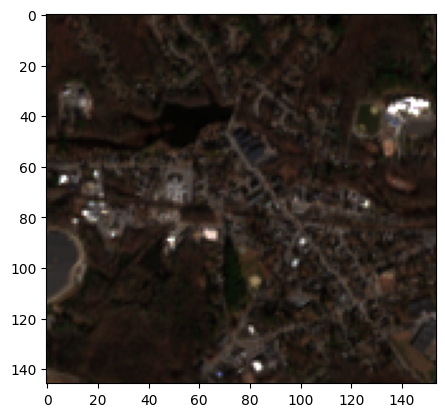

In [10]:
import matplotlib.pyplot as plt

rgb = x[[3, 2, 1], ...] / 4000
plt.imshow(rgb.transpose(1, 2, 0))

Now the original labels from Massachuset dataset

In [ ]:

from glob import glob

labels = glob("/home/alba/eotdl/MassachusettsRoads_dataS2/labels/*.tif")
labels


['/home/alba/eotdl/MassachusettsRoads_dataS2/labels/20428960_15.tif',
 '/home/alba/eotdl/MassachusettsRoads_dataS2/labels/24328795_15.tif',
 '/home/alba/eotdl/MassachusettsRoads_dataS2/labels/15628825_15.tif',
 '/home/alba/eotdl/MassachusettsRoads_dataS2/labels/24329215_15.tif',
 '/home/alba/eotdl/MassachusettsRoads_dataS2/labels/23129110_15.tif',
 '/home/alba/eotdl/MassachusettsRoads_dataS2/labels/21779035_15.tif',
 '/home/alba/eotdl/MassachusettsRoads_dataS2/labels/22528870_15.tif',
 '/home/alba/eotdl/MassachusettsRoads_dataS2/labels/18178885_15.tif',
 '/home/alba/eotdl/MassachusettsRoads_dataS2/labels/27028675_15.tif',
 '/home/alba/eotdl/MassachusettsRoads_dataS2/labels/25229260_15.tif',
 '/home/alba/eotdl/MassachusettsRoads_dataS2/labels/25828780_15.tif',
 '/home/alba/eotdl/MassachusettsRoads_dataS2/labels/23129065_15.tif',
 '/home/alba/eotdl/MassachusettsRoads_dataS2/labels/10228675_15.tif',
 '/home/alba/eotdl/MassachusettsRoads_dataS2/labels/24028540_15.tif',
 '/home/alba/eotdl/M

/home/alba/eotdl/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


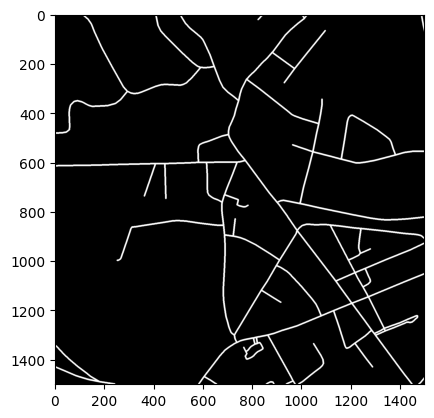

In [12]:
import rasterio as rio

x_l = rio.open('/home/alba/eotdl/MassachusettsRoads_dataS2/labels/20278900_15.tif').read()

plt.imshow(x_l[0], cmap='gray')

Now we want to visualize the together to check if they match. For that we have also to resize them since they have different resolution.

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from glob import glob
import cv2

def extract_id(path):
    """Extract the unique identifier from a file path."""
    # Extract the number_number_number part from paths like 'data/sentinel_images/22079050_15/sentinel-2-l2a_2024-11-17.tiff'
    match = re.search(r'(\d+_\d+)', path)
    if match:
        return match.group(1)
    return None

def find_matching_label(image_id, labels):
    """Find the corresponding label for an image ID."""
    for label in labels:
        if image_id in label:
            return label
    return None

def get_available_examples(image_paths, label_paths):
    """Get all available examples that have both images and labels."""
    # Create dictionary of all image groups by ID
    image_groups = {}
    for img in image_paths:
        img_id = extract_id(img)
        if img_id:
            if img_id not in image_groups:
                image_groups[img_id] = []
            image_groups[img_id].append(img)
    
    # Find all IDs that have matching labels
    available_examples = []
    for img_id, img_list in image_groups.items():
        label_file = find_matching_label(img_id, label_paths)
        if label_file:
            available_examples.append({
                'id': img_id,
                'images': sorted(img_list),  # Sort by date
                'label': label_file
            })
    
    return available_examples

def resize_and_save_all_labels(base_dir):
    """
    Resize all labels to match their corresponding images and save to labels_resized folder.
    
    Args:
        base_dir (str): Base directory containing 'labels' and 'train' folders
                       e.g., './eotdl/MassachusettsRoads_dataS2'
    """
    
    # Define paths
    labels_dir = os.path.join(base_dir, 'labels')
    images_dir = os.path.join(base_dir, 'train')
    labels_resized_dir = os.path.join(base_dir, 'labels_resized')
    
    # Create the labels_resized directory if it doesn't exist
    os.makedirs(labels_resized_dir, exist_ok=True)
    
    # Get all image and label paths
    image_paths = glob(os.path.join(images_dir, '*.tiff'))
    label_paths = glob(os.path.join(labels_dir, '*.tif'))
    
    print(f"Found {len(image_paths)} images and {len(label_paths)} labels")
    
    # Get all available examples (matching image-label pairs)
    examples = get_available_examples(image_paths, label_paths)
    
    print(f"Found {len(examples)} matching image-label pairs")
    
    processed_count = 0
    error_count = 0
    
    for example in examples:
        try:
            # Get the most recent image (last in the sorted list)
            img_file = example['images'][-1]  # Use the most recent image
            label_file = example['label']
            
            print(f"Processing ID: {example['id']}")
            print(f"  Image: {os.path.basename(img_file)}")
            print(f"  Label: {os.path.basename(label_file)}")
            
            # Read image to get dimensions
            with rio.open(img_file) as img_src:
                img_data = img_src.read()
                img_profile = img_src.profile
                _, img_height, img_width = img_data.shape
                
            # Read label
            with rio.open(label_file) as label_src:
                label_data = label_src.read()
                label_profile = label_src.profile
                
            print(f"  Original label shape: {label_data.shape}")
            print(f"  Target image shape: {img_data.shape}")
            
            # Check if resizing is needed
            if label_data.shape[1:] != (img_height, img_width):
                print(f"  Resizing label from {label_data.shape[1:]} to {(img_height, img_width)}")
                
                # Resize label to match image dimensions using nearest neighbor interpolation
                resized_label = cv2.resize(
                    label_data[0], 
                    (img_width, img_height), 
                    interpolation=cv2.INTER_NEAREST
                )
                
                # Add the channel dimension back
                resized_label = resized_label[np.newaxis, ...]
            else:
                print("  No resizing needed - dimensions already match")
                resized_label = label_data
            
            # Create output filename
            label_filename = os.path.basename(label_file)
            output_path = os.path.join(labels_resized_dir, label_filename)
            
            # Update profile for the resized label
            output_profile = label_profile.copy()
            output_profile.update({
                'height': img_height,
                'width': img_width,
                'transform': img_profile['transform']  # Use the image's transform
            })
            
            # Save the resized label
            with rio.open(output_path, 'w', **output_profile) as dst:
                dst.write(resized_label)
            
            print(f"  Saved: {output_path}")
            processed_count += 1
            
        except Exception as e:
            print(f"ERROR processing {example['id']}: {str(e)}")
            error_count += 1
            continue
    
    print(f"\n=== SUMMARY ===")
    print(f"Successfully processed: {processed_count} labels")
    print(f"Errors encountered: {error_count}")
    print(f"Labels saved to: {labels_resized_dir}")

def list_available_examples(image_paths, label_paths):
    """List all available examples with their IDs and paths."""
    examples = get_available_examples(image_paths, label_paths)
    print(f"Found {len(examples)} examples with matching images and labels:")
    
    for i, example in enumerate(examples):
        print(f"[{i}] ID: {example['id']}")
        print(f"    Label: {os.path.basename(example['label'])}")
        print(f"    Images ({len(example['images'])}):")
        for img in example['images']:
            print(f"      - {os.path.basename(img)}")
        print()
    
    return examples

def verify_resized_labels(base_dir, selected_ids=None, figsize=(20, 12), bands=(3, 2, 1), normalize=4000):
    """
    Visualize original vs resized labels to verify the resizing worked correctly.
    
    Args:
        base_dir (str): Base directory containing all folders
        selected_ids (list): List of IDs to check (if None, shows first 3)
        figsize (tuple): Figure size
        bands (tuple): Which bands to use for RGB visualization
        normalize (float): Value to normalize band values by
    """
    
    # Define paths
    labels_dir = os.path.join(base_dir, 'labels')
    images_dir = os.path.join(base_dir, 'train')
    labels_resized_dir = os.path.join(base_dir, 'labels_resized')
    
    # Check if resized labels directory exists
    if not os.path.exists(labels_resized_dir):
        print(f"Resized labels directory not found: {labels_resized_dir}")
        print("Please run resize_and_save_all_labels() first.")
        return
    
    # Get all paths
    image_paths = glob(os.path.join(images_dir, '*.tiff'))
    label_paths = glob(os.path.join(labels_dir, '*.tif'))
    resized_label_paths = glob(os.path.join(labels_resized_dir, '*.tif'))
    
    # Get available examples
    examples = get_available_examples(image_paths, label_paths)
    
    # Select which examples to show
    if selected_ids is None:
        # Show first 3 examples
        selected_examples = examples[:3]
    else:
        selected_examples = [ex for ex in examples if ex['id'] in selected_ids]
    
    if not selected_examples:
        print("No examples found to display")
        return
    
    # Create figure: 4 columns (Image, Original Label, Resized Label, Overlay)
    num_examples = len(selected_examples)
    fig, axes = plt.subplots(num_examples, 4, figsize=figsize)
    
    # Handle single example case
    if num_examples == 1:
        axes = axes.reshape(1, -1)
    
    for i, example in enumerate(selected_examples):
        try:
            # Get file paths
            img_file = example['images'][-1]  # Most recent image
            original_label_file = example['label']
            resized_label_file = os.path.join(labels_resized_dir, os.path.basename(original_label_file))
            
            print(f"Checking ID: {example['id']}")
            
            # Check if resized label exists
            if not os.path.exists(resized_label_file):
                print(f"  Warning: Resized label not found: {resized_label_file}")
                continue
            
            # Read image
            with rio.open(img_file) as src:
                img_data = src.read()
            
            # Read original label
            with rio.open(original_label_file) as src:
                original_label = src.read()
            
            # Read resized label
            with rio.open(resized_label_file) as src:
                resized_label = src.read()
            
            print(f"  Image shape: {img_data.shape}")
            print(f"  Original label shape: {original_label.shape}")
            print(f"  Resized label shape: {resized_label.shape}")
            
            # 1. Plot the image
            rgb = img_data[list(bands), ...] / normalize
            rgb = np.clip(rgb, 0, 1)
            axes[i, 0].imshow(np.transpose(rgb, (1, 2, 0)))
            axes[i, 0].set_title(f'Image\n{example["id"]}\n{img_data.shape}')
            axes[i, 0].axis('off')
            
            # 2. Plot original label
            axes[i, 1].imshow(original_label[0], cmap='gray', vmin=0, vmax=1)
            axes[i, 1].set_title(f'Original Label\n{original_label.shape}')
            axes[i, 1].axis('off')
            
            # 3. Plot resized label
            axes[i, 2].imshow(resized_label[0], cmap='gray', vmin=0, vmax=1)
            axes[i, 2].set_title(f'Resized Label\n{resized_label.shape}')
            axes[i, 2].axis('off')
            
            # 4. Plot overlay of image with resized label
            axes[i, 3].imshow(np.transpose(rgb, (1, 2, 0)))
            
            # Create overlay
            _, img_height, img_width = img_data.shape
            label_overlay = np.zeros((img_height, img_width, 4))
            label_overlay[..., 0] = 1.0  # Red
            label_overlay[..., 1] = 1.0  # Green  
            label_overlay[..., 2] = 1.0  # Blue
            label_overlay[..., 3] = (resized_label[0] > 0) * 0.7  # Alpha
            
            axes[i, 3].imshow(label_overlay)
            axes[i, 3].set_title(f'Image + Resized Label\nOverlay')
            axes[i, 3].axis('off')
            
            # Print statistics
            print(f"  Original label - Min: {original_label.min()}, Max: {original_label.max()}, Road pixels: {(original_label > 0).sum()}")
            print(f"  Resized label - Min: {resized_label.min()}, Max: {resized_label.max()}, Road pixels: {(resized_label > 0).sum()}")
            
        except Exception as e:
            print(f"Error processing {example['id']}: {e}")
            # Fill with blank plots
            for j in range(4):
                axes[i, j].text(0.5, 0.5, f'Error\n{example["id"]}', 
                               ha='center', va='center', transform=axes[i, j].transAxes)
                axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Verification: Original vs Resized Labels', fontsize=16, y=0.98)
    plt.show()
    
    return fig, axes

def compare_label_statistics(base_dir):
    """
    Compare statistics between original and resized labels.
    """
    labels_dir = os.path.join(base_dir, 'labels')
    labels_resized_dir = os.path.join(base_dir, 'labels_resized')
    
    if not os.path.exists(labels_resized_dir):
        print("Resized labels directory not found. Run resize_and_save_all_labels() first.")
        return
    
    # Get all label files
    original_labels = glob(os.path.join(labels_dir, '*.tif'))
    
    print(f"{'ID':<15} {'Original Shape':<15} {'Resized Shape':<15} {'Orig Roads':<12} {'Resized Roads':<12} {'Ratio':<8}")
    print("-" * 90)
    
    for orig_path in original_labels:
        try:
            # Find corresponding resized label
            label_filename = os.path.basename(orig_path)
            resized_path = os.path.join(labels_resized_dir, label_filename)
            
            if not os.path.exists(resized_path):
                continue
            
            # Extract ID
            img_id = extract_id(orig_path)
            
            # Read both labels
            with rio.open(orig_path) as src:
                orig_data = src.read()
            
            with rio.open(resized_path) as src:
                resized_data = src.read()
            
            # Calculate statistics
            orig_roads = (orig_data > 0).sum()
            resized_roads = (resized_data > 0).sum()
            ratio = resized_roads / orig_roads if orig_roads > 0 else 0
            
            print(f"{img_id:<15} {str(orig_data.shape[1:]):<15} {str(resized_data.shape[1:]):<15} "
                  f"{orig_roads:<12} {resized_roads:<12} {ratio:<8.3f}")
            
        except Exception as e:
            print(f"Error with {os.path.basename(orig_path)}: {e}")

def visualize_resized_labels_overlay(base_dir, num_examples=3, selected_ids=None, start_index=0, figsize=(15, 10), bands=(3, 2, 1), normalize=4000):
    """
    Visualize images with resized label overlays.
    
    Parameters:
    -----------
    base_dir : str
        Base directory containing 'labels', 'train', and 'labels_resized' folders
    num_examples : int, optional
        Number of examples to show (default: 3). Ignored if selected_ids is provided.
    selected_ids : list, optional
        List of specific IDs to visualize (e.g., ['22079050_15', '24179095_15'])
        If provided, num_examples and start_index are ignored.
    start_index : int, optional
        Starting index for examples (default: 0). Use with num_examples to show a range.
    figsize : tuple, optional
        Figure size (default: (15, 10))
    bands : tuple, optional
        Which bands to use for RGB visualization (default: (3,2,1))
    normalize : float, optional
        Value to normalize band values by (default: 4000)
    
    Returns:
    --------
    fig, axes : matplotlib objects
    """
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    import rasterio as rio
    from glob import glob
    import cv2
    import re
    
    def extract_id(path):
        """Extract the unique identifier from a file path."""
        match = re.search(r'(\d+_\d+)', path)
        if match:
            return match.group(1)
        return None

    def find_matching_label(image_id, labels):
        """Find the corresponding label for an image ID."""
        for label in labels:
            if image_id in label:
                return label
        return None

    def get_available_examples(image_paths, label_paths):
        """Get all available examples that have both images and labels."""
        # Create dictionary of all image groups by ID
        image_groups = {}
        for img in image_paths:
            img_id = extract_id(img)
            if img_id:
                if img_id not in image_groups:
                    image_groups[img_id] = []
                image_groups[img_id].append(img)
        
        # Find all IDs that have matching labels
        available_examples = []
        for img_id, img_list in image_groups.items():
            label_file = find_matching_label(img_id, label_paths)
            if label_file:
                available_examples.append({
                    'id': img_id,
                    'images': sorted(img_list),  # Sort by date
                    'label': label_file
                })
        
        return available_examples
    
    # Define paths
    labels_dir = os.path.join(base_dir, 'labels')
    images_dir = os.path.join(base_dir, 'train')
    labels_resized_dir = os.path.join(base_dir, 'labels_resized')
    
    # Check if resized labels directory exists
    if not os.path.exists(labels_resized_dir):
        print(f"Resized labels directory not found: {labels_resized_dir}")
        print("Please run resize_and_save_all_labels() first.")
        return None, None
    
    # Get all paths
    image_paths = glob(os.path.join(images_dir, '*.tiff'))
    label_paths = glob(os.path.join(labels_dir, '*.tif'))
    
    # Get available examples
    examples = get_available_examples(image_paths, label_paths)
    
    if not examples:
        print("No matching examples found")
        return None, None
    
    # Select which examples to show
    if selected_ids is not None:
        selected_examples = [ex for ex in examples if ex['id'] in selected_ids]
        if not selected_examples:
            print(f"No examples found for IDs: {selected_ids}")
            return None, None
    else:
        # Show examples from start_index to start_index + num_examples
        end_index = min(start_index + num_examples, len(examples))
        if start_index >= len(examples):
            print(f"Start index {start_index} is beyond available examples ({len(examples)})")
            return None, None
        selected_examples = examples[start_index:end_index]
        print(f"Showing examples {start_index} to {end_index-1} (total: {len(examples)} available)")
    
    num_to_show = len(selected_examples)
    if selected_ids is not None:
        print(f"Showing {num_to_show} examples with resized label overlays for selected IDs")
    else:
        print(f"Showing {num_to_show} examples with resized label overlays (indices {start_index} to {start_index + num_to_show - 1})")
    
    # Create figure with subplots - one column for overlay
    fig, axes = plt.subplots(num_to_show, 1, figsize=figsize)
    
    # Handle the case when there's only one example
    if num_to_show == 1:
        axes = [axes]
    
    # For each selected example
    for i, example in enumerate(selected_examples):
        try:
            # Get file paths
            img_file = example['images'][-1]  # Most recent image
            resized_label_file = os.path.join(labels_resized_dir, os.path.basename(example['label']))
            
            # Check if resized label exists
            if not os.path.exists(resized_label_file):
                print(f"Warning: Resized label not found for {example['id']}: {resized_label_file}")
                axes[i].text(0.5, 0.5, f"Resized label not found\n{example['id']}", 
                           ha='center', va='center', transform=axes[i].transAxes)
                axes[i].axis('off')
                continue
            
            # Read image
            with rio.open(img_file) as src:
                img_data = src.read()
            
            # Read resized label
            with rio.open(resized_label_file) as src:
                resized_label_data = src.read()
            
            print(f"ID: {example['id']} - Image: {img_data.shape}, Resized Label: {resized_label_data.shape}")
            
            # Create RGB composite
            rgb = img_data[list(bands), ...] / normalize
            rgb = np.clip(rgb, 0, 1)
            
            # Get spatial dimensions
            _, img_height, img_width = img_data.shape
            
            # Display the base satellite image
            axes[i].imshow(np.transpose(rgb, (1, 2, 0)))
            
            # Verify dimensions match (they should after resizing)
            if resized_label_data.shape[1:] != (img_height, img_width):
                print(f"Warning: Dimensions still don't match for {example['id']}")
                print(f"  Image: {(img_height, img_width)}, Label: {resized_label_data.shape[1:]}")
                # Resize again if needed
                resized_label = cv2.resize(
                    resized_label_data[0], 
                    (img_width, img_height), 
                    interpolation=cv2.INTER_NEAREST
                )
            else:
                resized_label = resized_label_data[0]
            
            # Create label overlay (roads in white with transparency)
            label_overlay = np.zeros((img_height, img_width, 4))
            label_overlay[..., 0] = 1.0  # Red channel (white)
            label_overlay[..., 1] = 1.0  # Green channel (white)
            label_overlay[..., 2] = 1.0  # Blue channel (white)
            label_overlay[..., 3] = (resized_label > 0) * 0.7  # Alpha channel (70% opacity for roads)
            
            # Overlay the resized label
            axes[i].imshow(label_overlay)
            
            # Count road pixels for info
            road_pixels = (resized_label > 0).sum()
            total_pixels = resized_label.size
            road_percentage = (road_pixels / total_pixels) * 100
            
            axes[i].set_title(f"ID: {example['id']} - Image with Resized Label Overlay\n"
                             f"Roads: {road_pixels:,} pixels ({road_percentage:.2f}%)")
            axes[i].axis('off')
            
        except Exception as e:
            print(f"Error processing example {example['id']}: {e}")
            axes[i].text(0.5, 0.5, f"Error processing\n{example['id']}\n{str(e)}", 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return fig, axes

In [ ]:
#####resize_and_save_all_labels #####

# Set your base directory path
base_directory = "./eotdl/MassachusettsRoads_dataS2"

# Process all labels and resize them to match their corresponding images
resize_and_save_all_labels(base_directory)

# Optional: List available examples to verify
image_paths = glob(os.path.join(base_directory, 'train', '*.tiff'))
label_paths = glob(os.path.join(base_directory, 'labels', '*.tif'))
examples = list_available_examples(image_paths, label_paths)

Found 1733 images and 1108 labels
Found 1101 matching image-label pairs
Processing ID: 17878960_15
  Image: 17878960_15_2025-03-19.tiff
  Label: 17878960_15.tif
  Original label shape: (1, 1500, 1500)
  Target image shape: (12, 146, 154)
  Resizing label from (1500, 1500) to (146, 154)
  Saved: /home/alba/eotdl/MassachusettsRoads_dataS2/labels_resized/17878960_15.tif
Processing ID: 21178975_15
  Image: 21178975_15_2025-03-19.tiff
  Label: 21178975_15.tif
  Original label shape: (1, 1500, 1500)
  Target image shape: (12, 146, 154)
  Resizing label from (1500, 1500) to (146, 154)
  Saved: /home/alba/eotdl/MassachusettsRoads_dataS2/labels_resized/21178975_15.tif
Processing ID: 22679455_15
  Image: 22679455_15_2024-11-17.tiff
  Label: 22679455_15.tif
  Original label shape: (1, 1500, 1500)
  Target image shape: (12, 145, 154)
  Resizing label from (1500, 1500) to (145, 154)
  Saved: /home/alba/eotdl/MassachusettsRoads_dataS2/labels_resized/22679455_15.tif
Processing ID: 18178900_15
  Image


VERIFYING RESIZED LABELS
Checking ID: 17878960_15
  Image shape: (12, 146, 154)
  Original label shape: (1, 1500, 1500)
  Resized label shape: (1, 146, 154)
  Original label - Min: 0, Max: 255, Road pixels: 88170
  Resized label - Min: 0, Max: 255, Road pixels: 878
Checking ID: 21178975_15
  Image shape: (12, 146, 154)
  Original label shape: (1, 1500, 1500)
  Resized label shape: (1, 146, 154)
  Original label - Min: 0, Max: 255, Road pixels: 118122
  Resized label - Min: 0, Max: 255, Road pixels: 1160
Checking ID: 22679455_15
  Image shape: (12, 145, 154)
  Original label shape: (1, 1500, 1500)
  Resized label shape: (1, 145, 154)
  Original label - Min: 0, Max: 255, Road pixels: 94749
  Resized label - Min: 0, Max: 255, Road pixels: 947


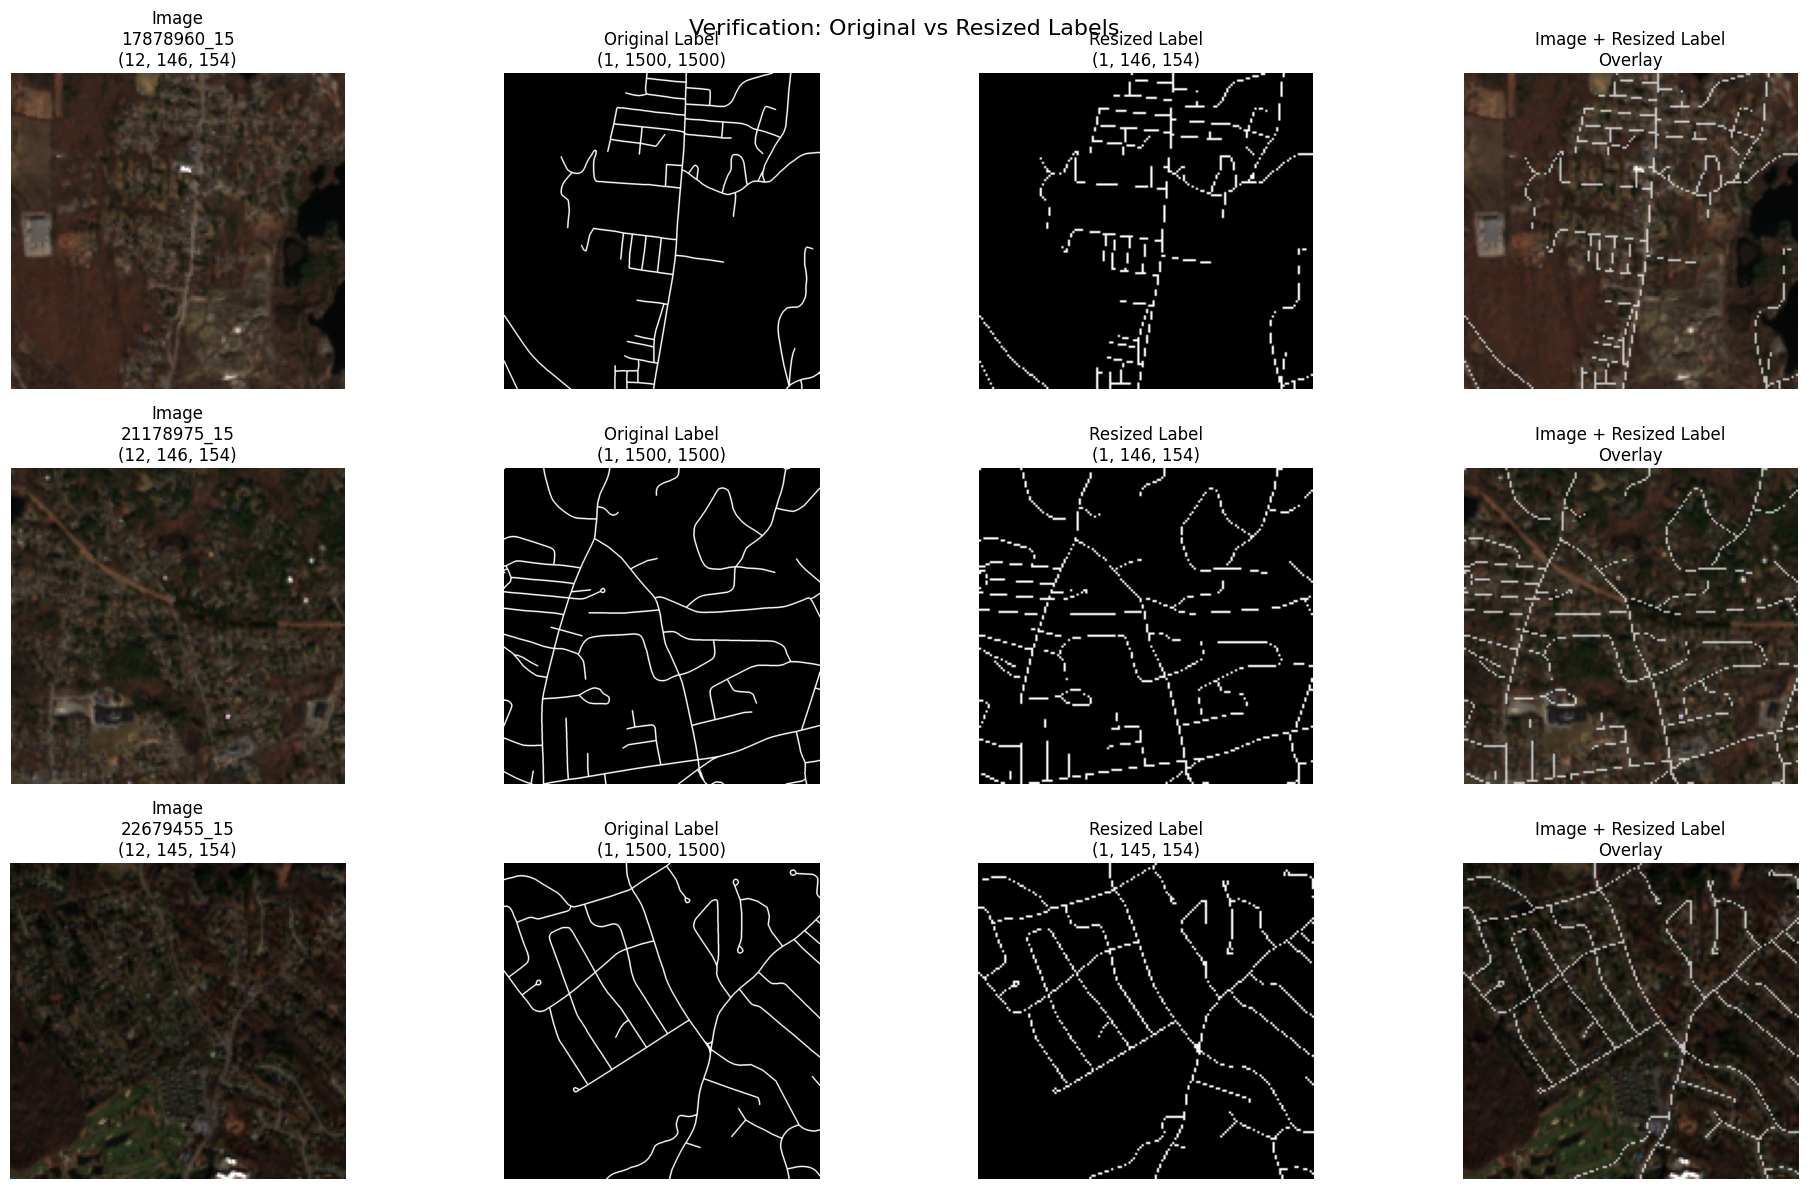


Statistics Comparison:
ID              Original Shape  Resized Shape   Orig Roads   Resized Roads Ratio   
------------------------------------------------------------------------------------------
20428960_15     (1500, 1500)    (146, 154)      77451        776          0.010   
24328795_15     (1500, 1500)    (146, 154)      30579        295          0.010   
15628825_15     (1500, 1500)    (156, 144)      33099        336          0.010   
24329215_15     (1500, 1500)    (146, 154)      116461       1182         0.010   
23129110_15     (1500, 1500)    (146, 154)      127698       1296         0.010   
21779035_15     (1500, 1500)    (146, 154)      94991        954          0.010   
22528870_15     (1500, 1500)    (146, 154)      87013        866          0.010   
18178885_15     (1500, 1500)    (146, 154)      61789        633          0.010   
27028675_15     (1500, 1500)    (146, 154)      14085        137          0.010   
25229260_15     (1500, 1500)    (145, 154)      45104 

In [ ]:
# Verify the results with visualizations
print("\n" + "="*50)
print("VERIFYING RESIZED LABELS")
print("="*50)

# Show comparison plots
verify_resized_labels(base_directory)

# Show statistics comparison
print("\nStatistics Comparison:")
compare_label_statistics(base_directory)

# Optional: List available examples to verify
image_paths = glob(os.path.join(base_directory, 'train', '*.tiff'))
label_paths = glob(os.path.join(base_directory, 'labels', '*.tif'))
examples = list_available_examples(image_paths, label_paths)

Now we want to see some examples. We can set the start index and the number of examples

Showing examples 90 to 99 (total: 1084 available)
Showing 10 examples with resized label overlays (indices 90 to 99)
ID: 23279170_15 - Image: (12, 146, 154), Resized Label: (1, 146, 154)
ID: 25079230_15 - Image: (12, 146, 154), Resized Label: (1, 146, 154)
ID: 17728885_15 - Image: (12, 146, 154), Resized Label: (1, 146, 154)
ID: 23579065_15 - Image: (12, 146, 154), Resized Label: (1, 146, 154)
ID: 18178975_15 - Image: (12, 146, 154), Resized Label: (1, 146, 154)
ID: 20128960_15 - Image: (12, 146, 154), Resized Label: (1, 146, 154)
ID: 17278945_15 - Image: (12, 146, 154), Resized Label: (1, 146, 154)
ID: 22978900_15 - Image: (12, 146, 154), Resized Label: (1, 146, 154)
ID: 24029065_15 - Image: (12, 146, 154), Resized Label: (1, 146, 154)
ID: 10678885_15 - Image: (12, 156, 144), Resized Label: (1, 156, 144)


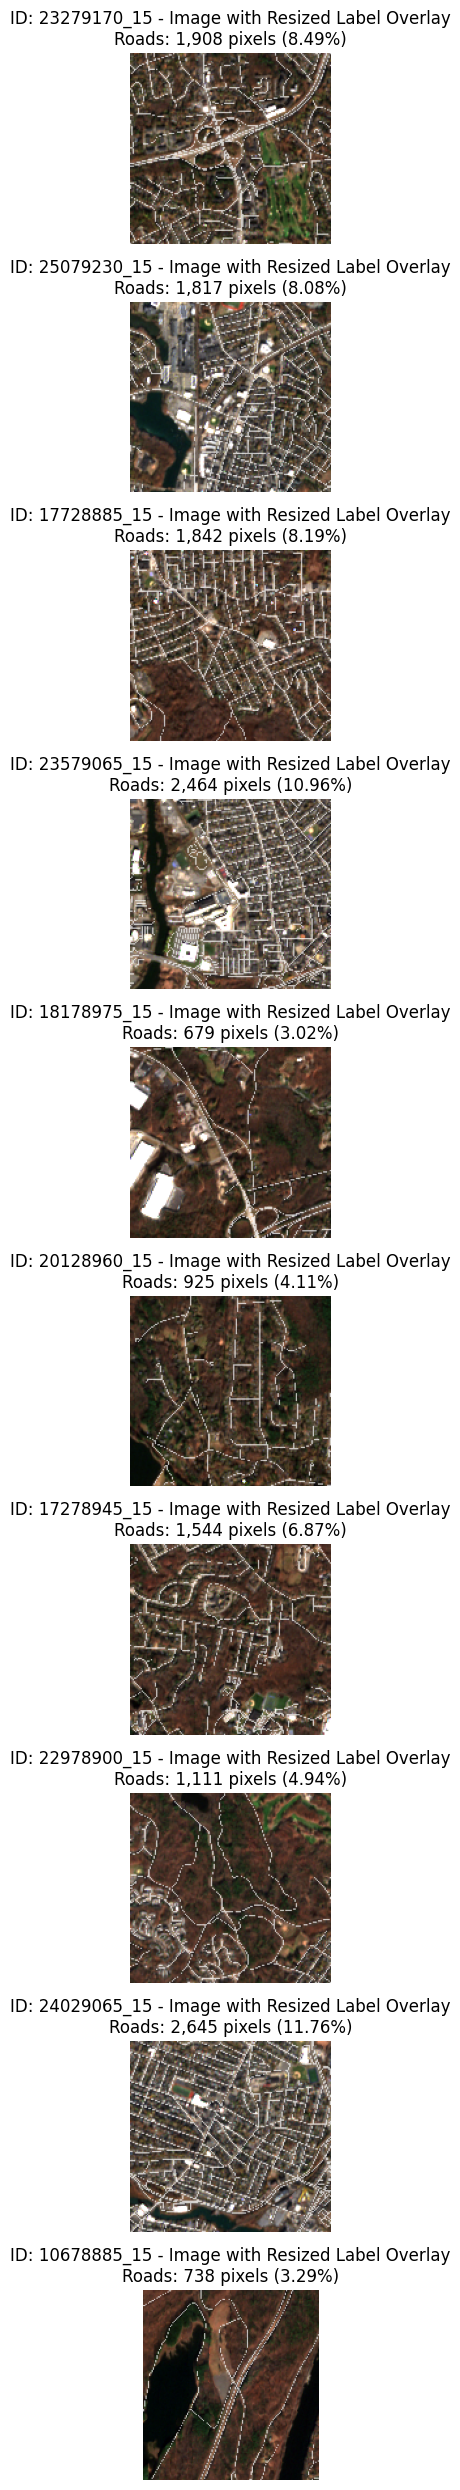

(<Figure size 2000x2500 with 10 Axes>,
 array([<Axes: title={'center': 'ID: 23279170_15 - Image with Resized Label Overlay\nRoads: 1,908 pixels (8.49%)'}>,
        <Axes: title={'center': 'ID: 25079230_15 - Image with Resized Label Overlay\nRoads: 1,817 pixels (8.08%)'}>,
        <Axes: title={'center': 'ID: 17728885_15 - Image with Resized Label Overlay\nRoads: 1,842 pixels (8.19%)'}>,
        <Axes: title={'center': 'ID: 23579065_15 - Image with Resized Label Overlay\nRoads: 2,464 pixels (10.96%)'}>,
        <Axes: title={'center': 'ID: 18178975_15 - Image with Resized Label Overlay\nRoads: 679 pixels (3.02%)'}>,
        <Axes: title={'center': 'ID: 20128960_15 - Image with Resized Label Overlay\nRoads: 925 pixels (4.11%)'}>,
        <Axes: title={'center': 'ID: 17278945_15 - Image with Resized Label Overlay\nRoads: 1,544 pixels (6.87%)'}>,
        <Axes: title={'center': 'ID: 22978900_15 - Image with Resized Label Overlay\nRoads: 1,111 pixels (4.94%)'}>,
        <Axes: title={'cente

In [ ]:
# Show first 10 examples 
base_directory = "/home/alba/eotdl/MassachusettsRoads_dataS2"
# Examples 10-20 
visualize_resized_labels_overlay(base_directory, start_index=90, num_examples=10, figsize=(20, 25), normalize=2000)



Now we are ready to use this data for train a model. But first let's upload it to EOTDL so we can call it from there:

In [ ]:
uv run eotdl auth login   

uv run eotdl datasets ingest -p ./eotdl/MassachusettsRoadsDatasetSentinel2